<a href="https://colab.research.google.com/github/Last-Vega/Klis_Workshop_MachineLearning/blob/master/CJSJ_ML_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorchによる画像処理

ここからは深層学習のプログラミングについて取り組んでいく．この授業では，いくつかある深層学習のライブラリの中から，PyTorchを扱う．他にもTensorFlowなどがあるが，柔軟性や研究開発における利用はPyTorchが勝っているのではないかと思われる．

今日の演習では，特に画像データ，および，テキストデータを読み込んで，簡単な深層学習モデルを作るまでを解説していく．

ここでは，自分で用意した画像データを読み込む方法について解説を行う．
今回は，猫と犬の画像を適当に集めてきて，人手で分類を行い，自らデータセットを作ったというシナリオで進めていく．


著作権の扱いについてはどう考えたら良いだろうか．一般的に，他者の著作物を無断で使用すると，著作権侵害となるが，以下の条文では，情報解析に用いるための利用は許可すると書かれている．今回はこれに該当する．

> 第三十条の四　著作物は、次に掲げる場合その他の当該著作物に表現された思想又は感情を自ら享受し又は他人に享受させることを目的としない場合には、その必要と認められる限度において、いずれの方法によるかを問わず、利用することができる。ただし、当該著作物の種類及び用途並びに当該利用の態様に照らし著作権者の利益を不当に害することとなる場合は、この限りでない。

> ･･･

> 二　情報解析（多数の著作物その他の大量の情報から、当該情報を構成する言語、音、影像その他の要素に係る情報を抽出し、比較、分類その他の解析を行うことをいう。第四十七条の五第一項第二号において同じ。）の用に供する場合

## 画像データセットの作り方

例えば2値分類を行う場合はあるフォルダ中に`0`と`1`という名前がついたフォルダを作り，
その中にそれぞれのクラスに該当する画像を入れておけば良い．今回は，0というフォルダに猫の画像，1というフォルダに犬の画像が含まれるようにして，データセットの作成を行った．

このデータは https://drive.google.com/file/d/1ldKEtetkjjuxPxRQ4-_9YHsD-u9VtxbA/view からダウンロードすることが可能である．

これをダウンロードして，Colabへアップロードし使えるようにしておこう．これを行うためには，画面左側にあるフォルダのアイコンをクリックし，以下のような画面でダウンロードしたcat_dog_images.zipをドラッグアンドドロップすればよい．ただし，Colabへアップロードされたデータは一定時間すると削除されてしまうため注意しよう．


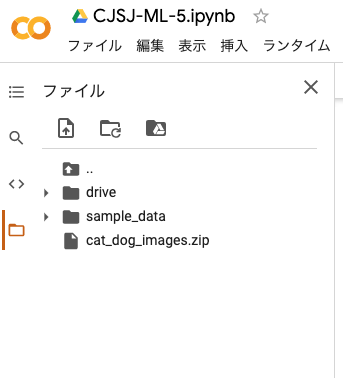


また，以下のページの内容をみて，Google Drive中のデータを読み書きする方法について確認しておこう．
https://colab.research.google.com/drive/12hivTvt_8UnBP26IQyqRzYm97nONq5fq?usp=sharing

## 画像データの読み込み

学習をする前に，まずはデータを読み込めるかどうかを試してみよう．

In [ ]:
# zipファイルを展開する
!unzip cat_dog_images.zip

In [ ]:
import torchvision # PyTorchの中でも特に画像データの扱いに特化したパッケージ
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# 画像に対して実行する前処理を定義するクラス
class ImageTransform():
    def __init__(self):
        self.data_transform = transforms.Compose([
            transforms.Resize((224, 224)), # 画像のサイズを揃える必要があるので224 x 224に統一
            transforms.ToTensor()
        ])
    
    def __call__(self, img):
        return self.data_transform(img)

# torchvision.datasets.ImageFolderは
# あるフォルダ中に含まれるフォルダ名をラベルとして，その中に含まれる画像はそのラベルが付与されていると解釈し，
# 画像データを読み込む
image_dir = "/content/cat_dog_images" # アップロードしたzipファイルがcat_dog_imagesというフォルダに展開されるはず
dataset = torchvision.datasets.ImageFolder(image_dir, transform=ImageTransform())
dataset

Dataset ImageFolder
    Number of datapoints: 207
    Root location: /content/cat_dog_images
    StandardTransform
Transform: <__main__.ImageTransform object at 0x7feae9c8fef0>

In [ ]:
from torch.utils.data import DataLoader, random_split

train_size = 167 # 先頭の167件を訓練データとして用いることにする
batch_size = 32 # ミニバッチのサイズを設定，増やしても減らしても良い

# 訓練データとテストデータに分割
train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset)-train_size])

# 訓練データを読み込むためのデータローダーを準備．shuffle=Trueはミニバッチを作る際に，画像の順序をランダムにするオプション．
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

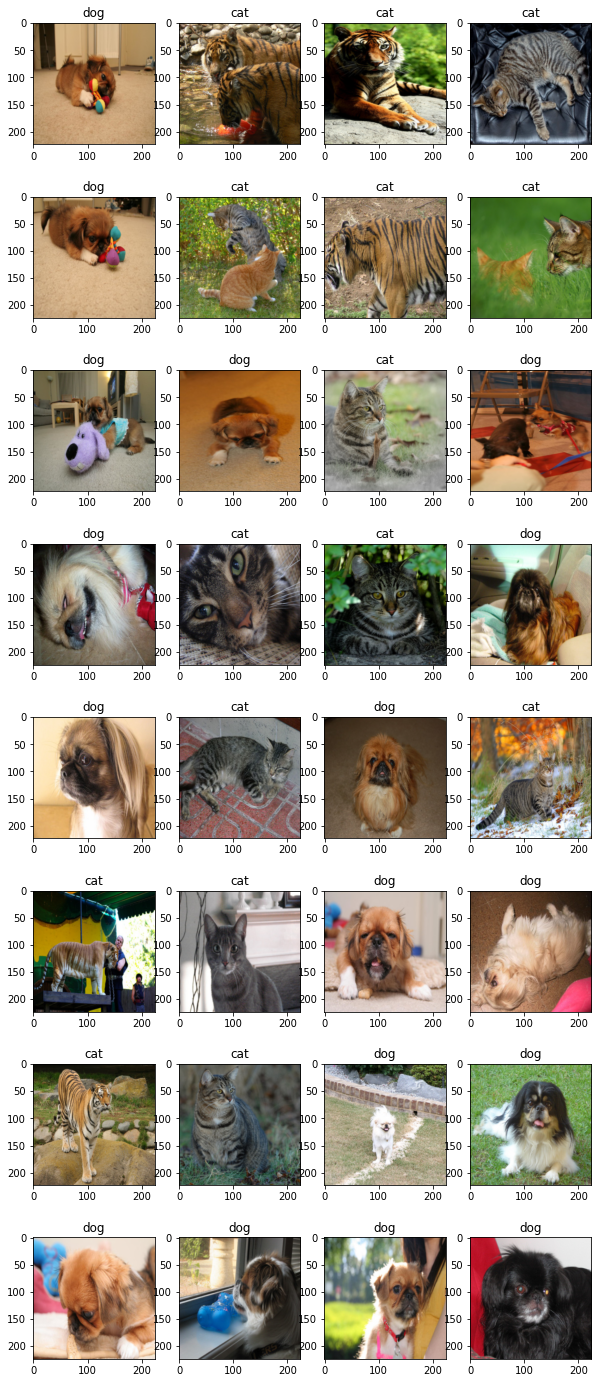

In [ ]:
# 1つ目のバッチを取り出して，1つ目のバッチの画像とラベルだけ表示させてみる
# `DataLoader`への引数が`shuffle=True`となっている場合，画像の順序がランダムになっているため，
# 実行するごとに読み込まれる画像が異なるはずである．

%matplotlib inline
# 上の行はmatplotlibというPythonパッケージをセル間に表示させるための設定
import matplotlib.pyplot as plt # matplotlibというPythonパッケージからpltモジュールをimportする
from PIL import Image # PILパッケージからImageモジュールをimportする
import numpy as np # numpyパッケージをimportする
 
fig = plt.figure(figsize=(10, 25)) # 10 x 25の画像表示域を確保

# データローダーはミニバッチ勾配降下法のために，`batch_size`で指定した数ごとにデータをわけて読み込んでくれる．
for images, labels in train_dataloader:
    # 得られたミニバッチ中の各画像を表示してみる
    for i in range(batch_size):
      im = images[i].permute(1, 2, 0) # 表示用の変換（以下で補足）
      ax = fig.add_subplot(8, 4, i+1) # 8行4列のうち，i+1番目のマスを選択
      label_name = "dog" if labels[i] == 1 else "cat" # ラベルが1なら犬，そうでなければ（ラベルが0なら）猫
      ax.set_title(label_name) # マスにタイトルを設定
      ax.imshow(im) # 画像を表示
    break # ミニバッチは複数あるが，1個読み込んだら終わるようにbreakをここに入れている

補足： torchvisionで読み込まれた画像は3 x 横ピクセル数 x 縦ピクセル数というテンソルとして読み込まれる．これは，横ピクセル数 x 縦ピクセル数 x 3という各ピクセルごとに色情報を保持するという従来の画像のデータ構造を少し変えたものになっている．`permute(1, 2, 0)`はこれらの異なるデータ構造の相互変換を行っている．

より具体的には，2x2の画像では，以下のような形式で画像は表現される．

```
[
  [
    [0,  10,  20],
    [10, 100, 50],
  ],
  [
    [100,  30,  0],
    [200,  20,  10],
  ]
]
```

これは，2x2のピクセルのうち，左上のピクセルの色がRGBで(0,  10,  20)，右下のピクセルの色がRGBで(200,  20,  10)となっていることを意味している．
torchvisionでは，これを以下のように変換している．

```
[
  [
    [0,   10],
    [100, 200]
  ],
  [
    [10, 100],
    [30, 20],
  ],
  [
    [20, 50],
    [0, 20],
  ]
]
```

つまり，RGBの各色ごとに，ピクセルの値を保持したようなデータ構造となっている．これは画像処理によく用いられる畳み込みニューラルネットワークが，このようなデータ構造を想定しているためである．


## 物体認識の機械学習モデル

ここでは，簡単な前向きネットワークによって物体認識をするモデルを構築してみよう．
（ただし，このようなモデルは一般的に物体認識で用いられないので注意すること）

PyTorchでは，ニューラルネットワークをクラスとして定義することになっている．
ここでは，2層のニューラルネットワークを定義することにする．
このモデルはロジスティック回帰よりかは複雑なモデルではあるが，一般的な物体認識で用いられるモデルよりかは単純なものである．

入力${\mathbf x}$（3 x 224 x 224のテンソル）に対して2層のニューラルネットワークは以下のように定義される：

$$f({\mathbf x}) = \sigma(f_2({\rm ReLU}(f_1({\mathbf x}'))))$$

ただし，$f_k = {\mathbf W}{\mathbf x}+{\mathbf b}$である．
つまり，全結合層と活性化関数ReLUを交互に適用し，最後にシグモイド関数を用いたモデルである．

なお，このモデルにおいて，シグモイド関数は含めない．なぜなら，後で用いる，交差エントロピーを計算する関数BCEWithLogitsLossはシグモイド関数を内部で適用し，シグモイド関数を適用する前の値を入力として期待するためである．

In [ ]:
# PyTochにおいてモデルを定義するのに必要なモジールを読み込む
# `nn`は層を含むモジュールで，ここでは全結合層`nn.Linear`を用いる．これはf(x) = Wx + bという関数に対応する．
# `functional`というモジュールに`F`という別名をつけて読み込んでいる．これはReLUなどパラメータを含まない関数が入っている．
import torch.nn as nn
import torch.nn.functional as F

class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__() # Pythonにおいてはこのようにして親クラスの__init__を呼ぶ（特に意識しなくて良い）

        # ニューラルネットワークモデルをPyTorchで構築するときは，データ属性（self.xxx のこと）として各層を定義する
        self.fc1 = nn.Linear(3 * 224 * 224, 512) # 512 x 3 * 224 * 224 の行列を含む全結合層を設定
        self.fc2 = nn.Linear(512, 1) # 1 x 512 の行列（この場合はベクトル）を含む全結合層を設定

    def forward(self, x):
        x = x.view(-1, 3 * 224 * 224) # 3 x 224 x 224のテンソルの各値を並べることで，3 * 224 * 224次元のベクトルに変換
        x = F.relu(self.fc1(x)) # fc1を適用した後，ReLU関数を適用
        h = self.fc2(x)  # fc3を適用．出力は1次元ベクトル（スカラ）となり，この値が犬である度合いを表すことを期待している
        h = h.squeeze() # hは`batch_size` x 1の**行列**になっているので，これを`batch_size`次元の**ベクトル**に変換
        return h

## 物体認識モデルの学習

訓練データを用いて先ほど定義した`ImageClassifier`モデルを学習してみよう．
学習にはミニバッチ勾配降下法を用いることにする．また，交差エントロピーを最小化するようなパラメータを採用することにする．なお，`ImageClassifier`クラスの`fc1`と`fc2`に含まれている行列およびベクトルが学習されるべきパラメータとなっている．

補足： 二値分類用の交差エントロピーとして，`BCELoss`という関数もあるが，こちらを用いた時には学習を重ねるごとに交差エントロピーが上昇していってしまった．そのため，`BCELoss`の改善版である`BCEWithLogitsLoss`を用いている．

In [ ]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # CPUもしくはGPUのどちらを使うかを設定
model = ImageClassifier() # ニューラルネットワークモデルのインスタンスを生成
model = model.to(device) # CPUもしくはGPUのどちらを設定
optimizer = optim.Adam(model.parameters()) # 基本的な学習方法はミニバッチ勾配降下法ではあるが，その中でもよく用いられるAdamと呼ばれる方法を用いることにする

criterion = nn.BCEWithLogitsLoss() # 二値分類用の交差エントロピーを最小化することにする

epoch_size = 10 # 勾配降下法はすべてのデータでパラメータを更新したら終わりではなく，全データでの更新（=1エポック）を複数回行う必要がある

model.train() # モデルを学習モードに変更

# `epoch_size`の数だけ以下を繰り返す
for epoch in range(epoch_size):
    losses = []
    # データローダーはミニバッチ勾配降下法のために，`batch_size`で指定した数ごとにデータをわけて読み込んでくれる．
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        optimizer.zero_grad() # 勾配の初期化
        y = model(images) # 現時点でのモデルの出力を得る
        loss = criterion(y, labels.type(torch.float)) # 交差エントロピーの計算
        loss.backward() # 交差エントロピーの勾配計算
        optimizer.step() # パラメータ更新
        losses.append(loss.item())

    # 現在の交差エントロピーを出力
    print('Epoch: {}\tCross Entropy: {:.6f}'.format(epoch, sum(losses)))

Epoch: 0	Cross Entropy: 206.018310
Epoch: 1	Cross Entropy: 83.725198
Epoch: 2	Cross Entropy: 58.339395
Epoch: 3	Cross Entropy: 32.923837
Epoch: 4	Cross Entropy: 22.072279
Epoch: 5	Cross Entropy: 23.860682
Epoch: 6	Cross Entropy: 18.433284
Epoch: 7	Cross Entropy: 4.837080
Epoch: 8	Cross Entropy: 6.071266
Epoch: 9	Cross Entropy: 7.671036


## 物体認識モデルの評価

学習されたニューラルネットワークモデルを評価してみよう．
訓練データにおいて機械学習モデルの交差エントロピーを最小化するようなパラメータは，
テストデータにおいて性能指標を最大化していることを期待するのである．

性能指標には精度を用いて予測結果を評価してみよう．

In [ ]:
correct = 0
model.eval() # モデルを評価モードに変更
for batch_idx, (images, labels) in enumerate(test_dataloader):
    y = model(images) # モデルの出力を得る
    result = torch.sigmoid(y) # `ImageClassifier`ではsigmoid関数を適用していなかったのでここで適用
    prediction = result >= 0.5 # `result`ベクトルと同じ次元を持ち，`result`の中で0.5以上である次元がTrue，それ以外がFalseであるベクトルを`prediction`とする
    target = labels == 1 # `labels`ベクトルと同じ次元を持ち，`labels`の中で1である次元がTrue，それ以外がFalseであるベクトルを`target`とする
    correct_num = target.eq(prediction).sum().item() # `prediction`ベクトルと`target`ベクトルでTrue/Falseが一致したものの数を数える
    correct += correct_num

# test_dataloader.datasetにはテストデータ全体が入っているので，これの長さはテストデータの事例数となる
print("Accuracy: {:.3f}".format(correct / len(test_dataloader.dataset)))

Accuracy: 0.550


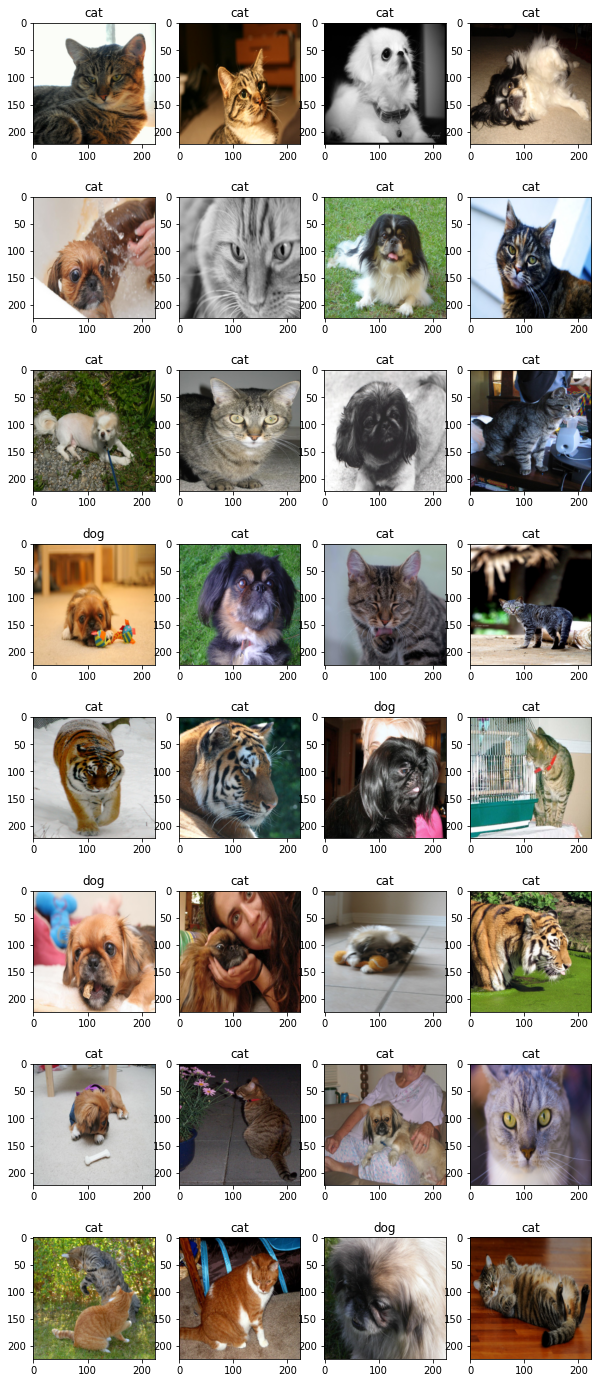

In [ ]:
# 予測結果を表示してみよう

fig = plt.figure(figsize=(10, 25)) # 10 x 25の画像表示域を確保

for images, labels in train_dataloader:
    images, labels = images.to(device), labels.to(device)
    y = model(images) # モデルの出力を得る
    result = torch.sigmoid(y) # `ImageClassifier`ではsigmoid関数を適用していなかったのでここで適用
    # 得られたミニバッチ中の各画像を表示してみる
    for i in range(batch_size):
      im = images[i].permute(1, 2, 0) # 表示用の変換（以下で補足）
      ax = fig.add_subplot(8, 4, i+1) # 8行4列のうち，i+1番目のマスを選択
      label_name = "dog" if result[i] >= 0.5 else "cat" # 結果が0.5以上なら犬，そうでなければ猫
      ax.set_title(label_name) # マスにタイトルを設定
      ax.imshow(im) # 画像を表示
    break # ミニバッチは複数あるが，1個読み込んだら終わるようにbreakをここに入れている

## 今回の物体認識モデルのまとめ

精度はどの程度であっただろうか．深層学習は学習するデータの順序や各パラメータの初期値がランダムであるため，実行する度に結果が変わる．二値分類であるため，0.5（犬猫同数の時，ランダムに予測すると精度が0.5になるはず）以上の精度は期待したいところであるが，予測精度はこれを上回っただろうか．

今回はデータ数も少なく，また，ニューラルネットワークも画像に対してよく用いられるようなモデルではなかった．そのため，期待したような精度は出なかったであろう．